In [ ]:
pip install scanpy

In [ ]:
pip install leidenalg

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
filename = '..../20200917_MGH_Broad_Villani_to_CZI.h5ad'
ann = sc.read(filename, backed=None, sheet=None, ext=None, delimiter=None, first_column_names=False, backup_url=None, cache=False)

In [6]:
ann.obs

Institute  ... trop_72h
cell                                             ...         
batch1_5p_rna|AAACCTGAGAAACGAG-1  MGH and Broad  ...        0
batch1_5p_rna|AAACCTGAGAGCTGCA-1  MGH and Broad  ...        0
batch1_5p_rna|AAACCTGAGAGTTGGC-1  MGH and Broad  ...        0
batch1_5p_rna|AAACCTGAGATCCCGC-1  MGH and Broad  ...        0
batch1_5p_rna|AAACCTGAGCAAATCA-1  MGH and Broad  ...        0
...                                         ...  ...      ...
batch4_5p_rna|TTTGTCATCCGAATGT-1  MGH and Broad  ...        0
batch4_5p_rna|TTTGTCATCCGATATG-1  MGH and Broad  ...        0
batch4_5p_rna|TTTGTCATCCTAGTGA-1  MGH and Broad  ...        0
batch4_5p_rna|TTTGTCATCTCGGACG-1  MGH and Broad  ...        1
batch4_5p_rna|TTTGTCATCTGCTGCT-1  MGH and Broad  ...        1

[59506 rows x 28 columns]

Filter COVID19 cases - D0

In [7]:
#Covid dataset 
ann = ann[ann.obs["covid"] == 1, :]

ann = ann[ann.obs["time_point"] == 'D0', :]

Select KITLG low protein expression levels patients

In [8]:
ann = ann[ann.obs["patient_id"].isin([161, 184, 259, 3, 336, 366, 90]) , :]

In [11]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=90, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.9.6 pynndescent==0.5.4


normalizing counts per cell
    finished (0:00:00)


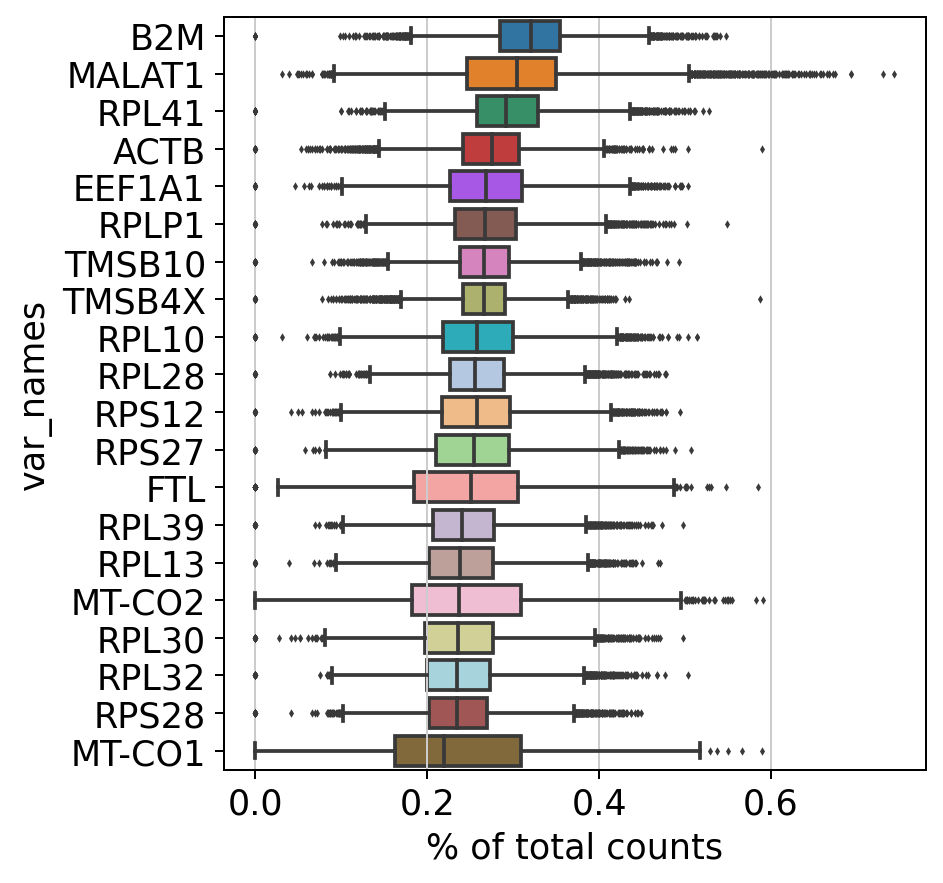

In [12]:
sc.pl.highest_expr_genes(ann, n_top=20, )

In [13]:
sc.pp.filter_cells(ann, min_genes=200)
sc.pp.filter_genes(ann, min_cells=3)

filtered out 5514 genes that are detected in less than 3 cells


In [14]:
ann.var['mt'] = ann.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(ann, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

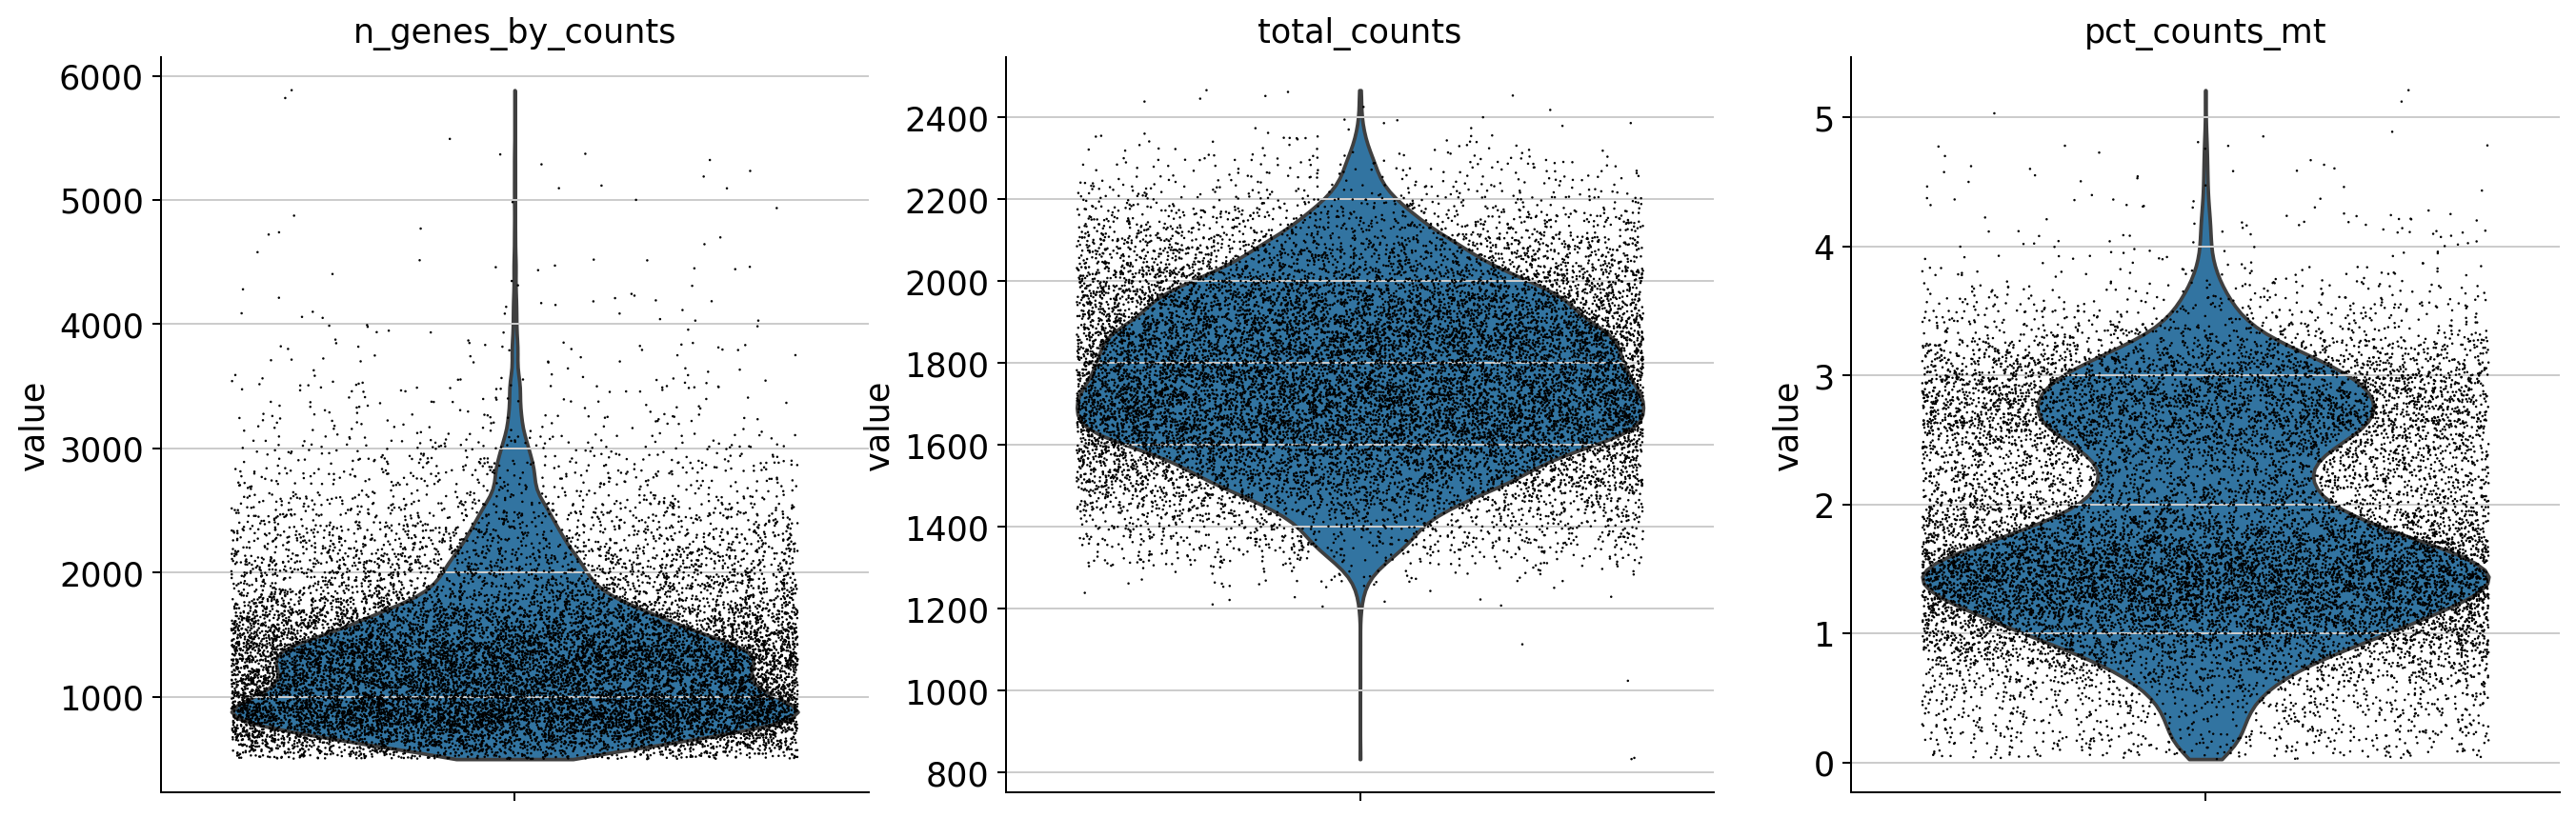

In [15]:
sc.pl.violin(ann, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

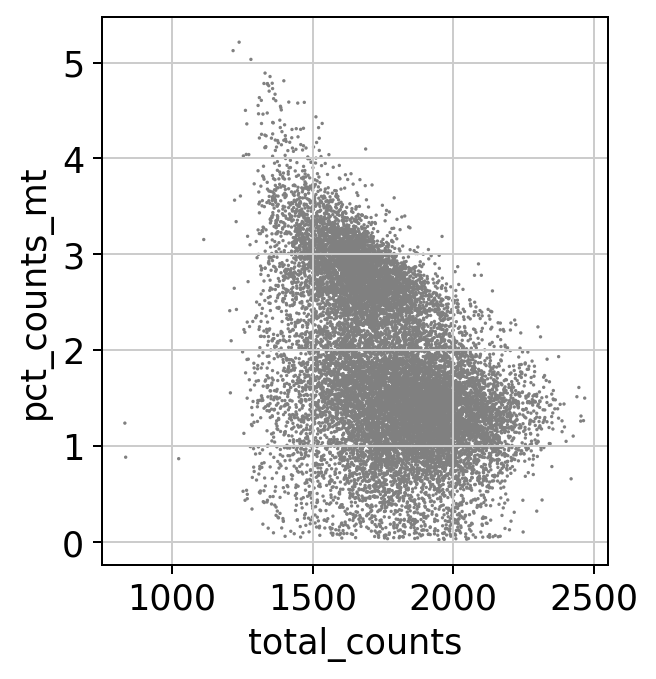

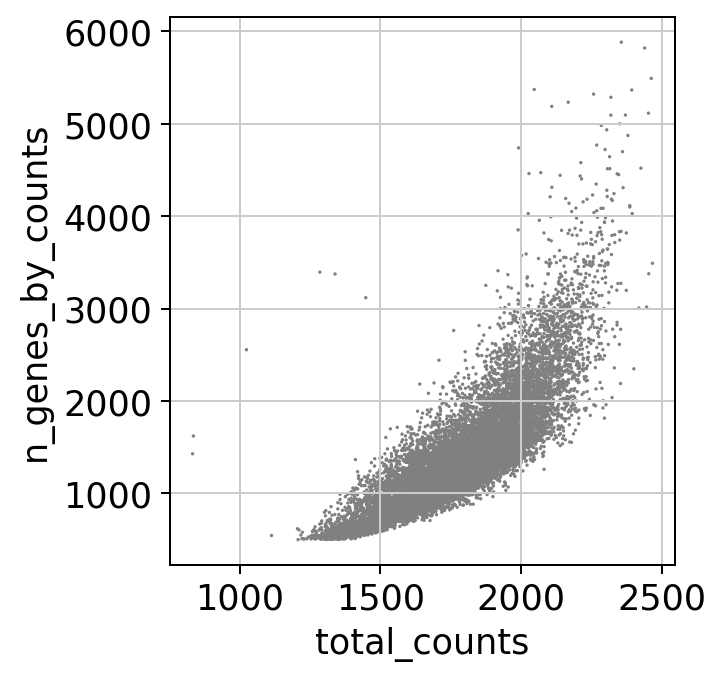

In [16]:
sc.pl.scatter(ann, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(ann, x='total_counts', y='n_genes_by_counts')

In [17]:
ann = ann[ann.obs.n_genes_by_counts < 2500, :]
ann = ann[ann.obs.pct_counts_mt < 5, :]

In [18]:
sc.pp.normalize_total(ann, target_sum=1e4)

normalizing counts per cell


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


In [19]:
sc.pp.log1p(ann)

In [20]:
sc.pp.highly_variable_genes(ann, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


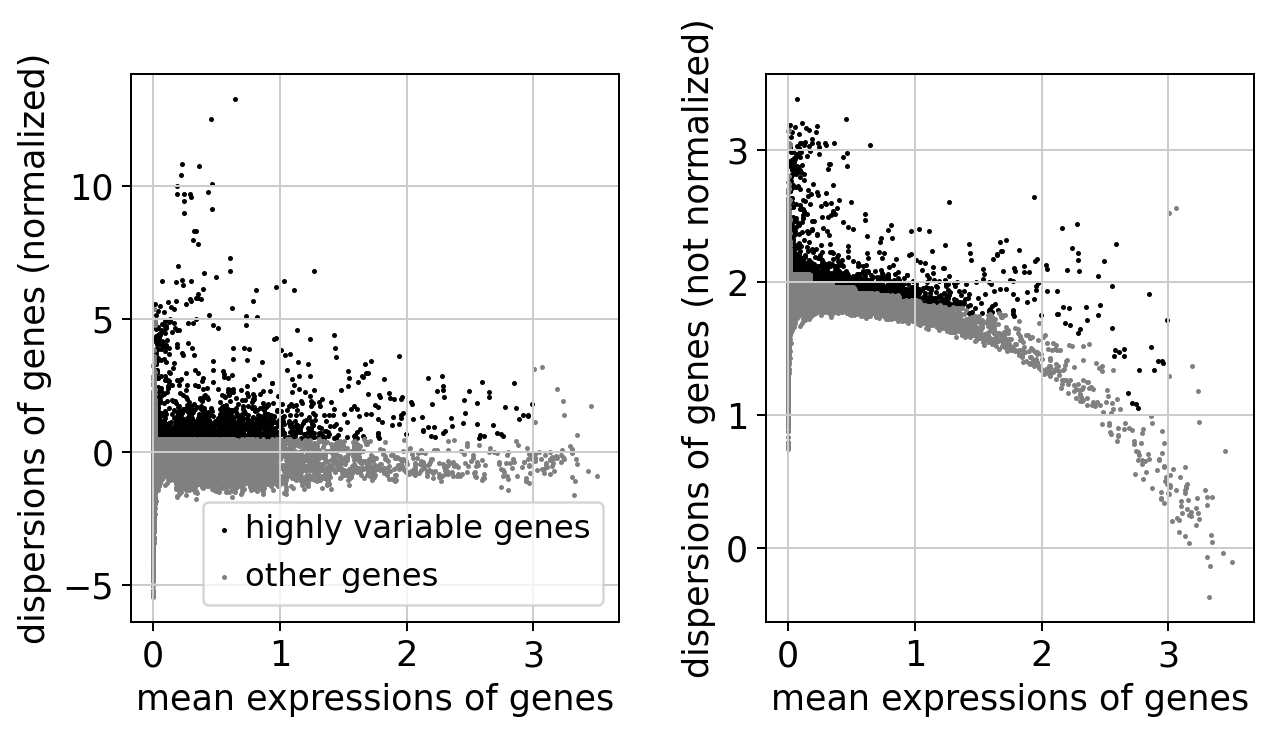

In [21]:
sc.pl.highly_variable_genes(ann)

In [22]:
ann.raw = ann

In [23]:
ann = ann[:, ann.var.highly_variable]

In [24]:
sc.pp.regress_out(ann, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:31)


In [25]:
sc.pp.scale(ann, max_value=10)

In [26]:
sc.tl.pca(ann, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)


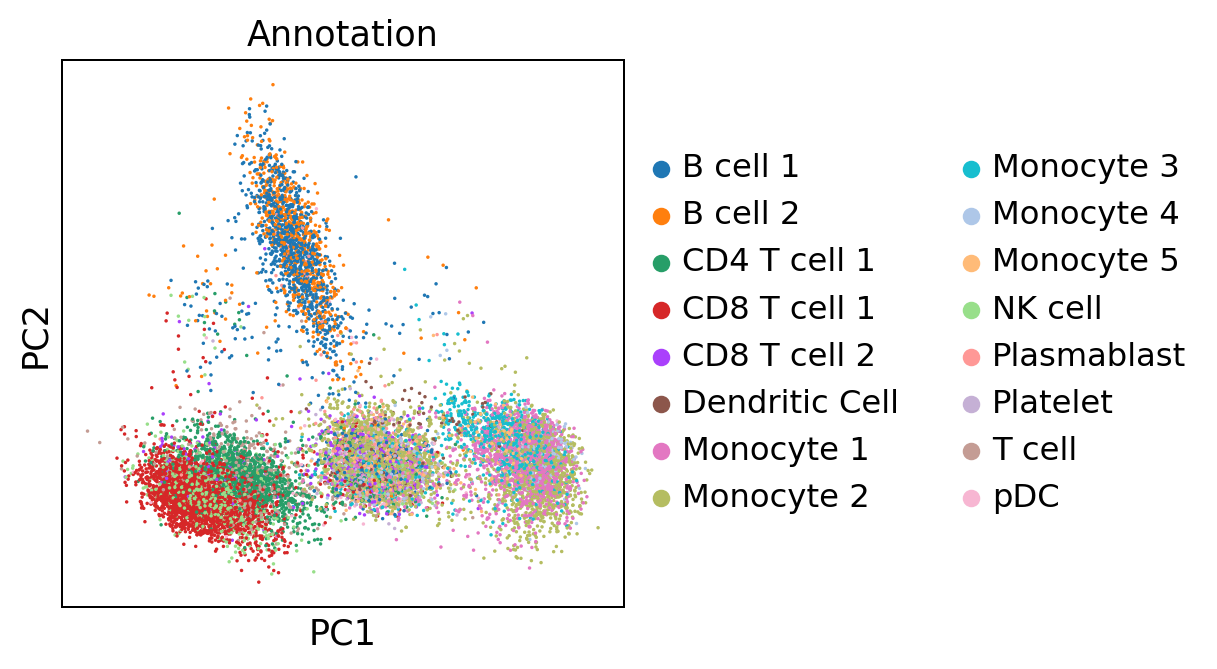

In [27]:
sc.pl.pca(ann, color='Annotation')

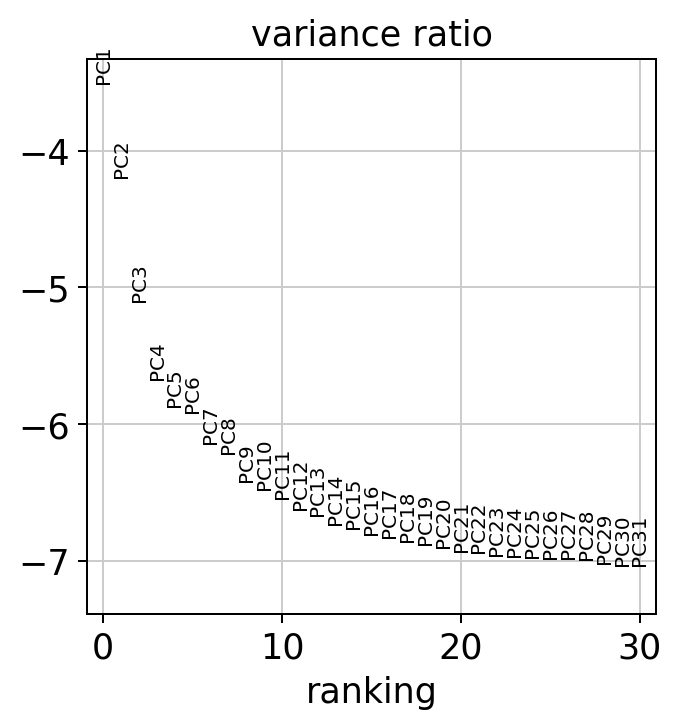

In [28]:
sc.pl.pca_variance_ratio(ann, log=True)

In [29]:
sc.pp.neighbors(ann, n_neighbors=10) 
# , n_neighbors=10, n_pcs=40

computing neighbors
    using 'X_pca' with n_pcs = 50


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)


In [30]:
sc.tl.umap(ann,)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


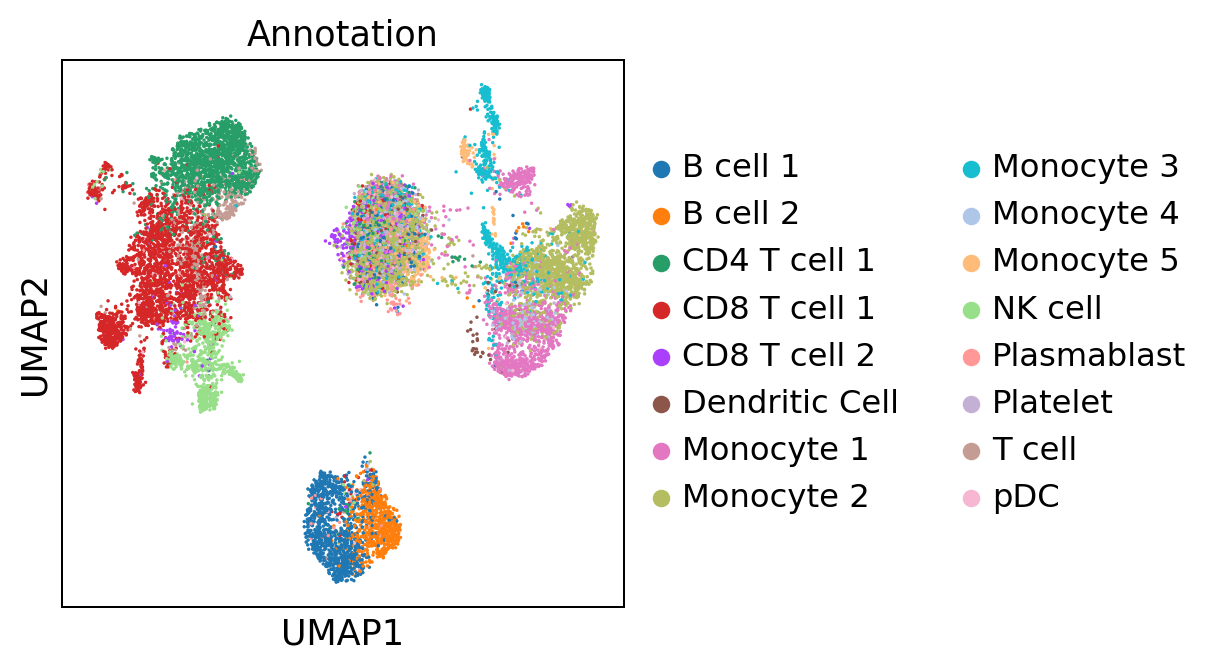

In [31]:
sc.pl.umap(ann, color=[ 'Annotation'], save='SCFlow.svg')

Clustering the neighborhood graph

In [32]:
sc.tl.leiden(ann)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Annotation']`


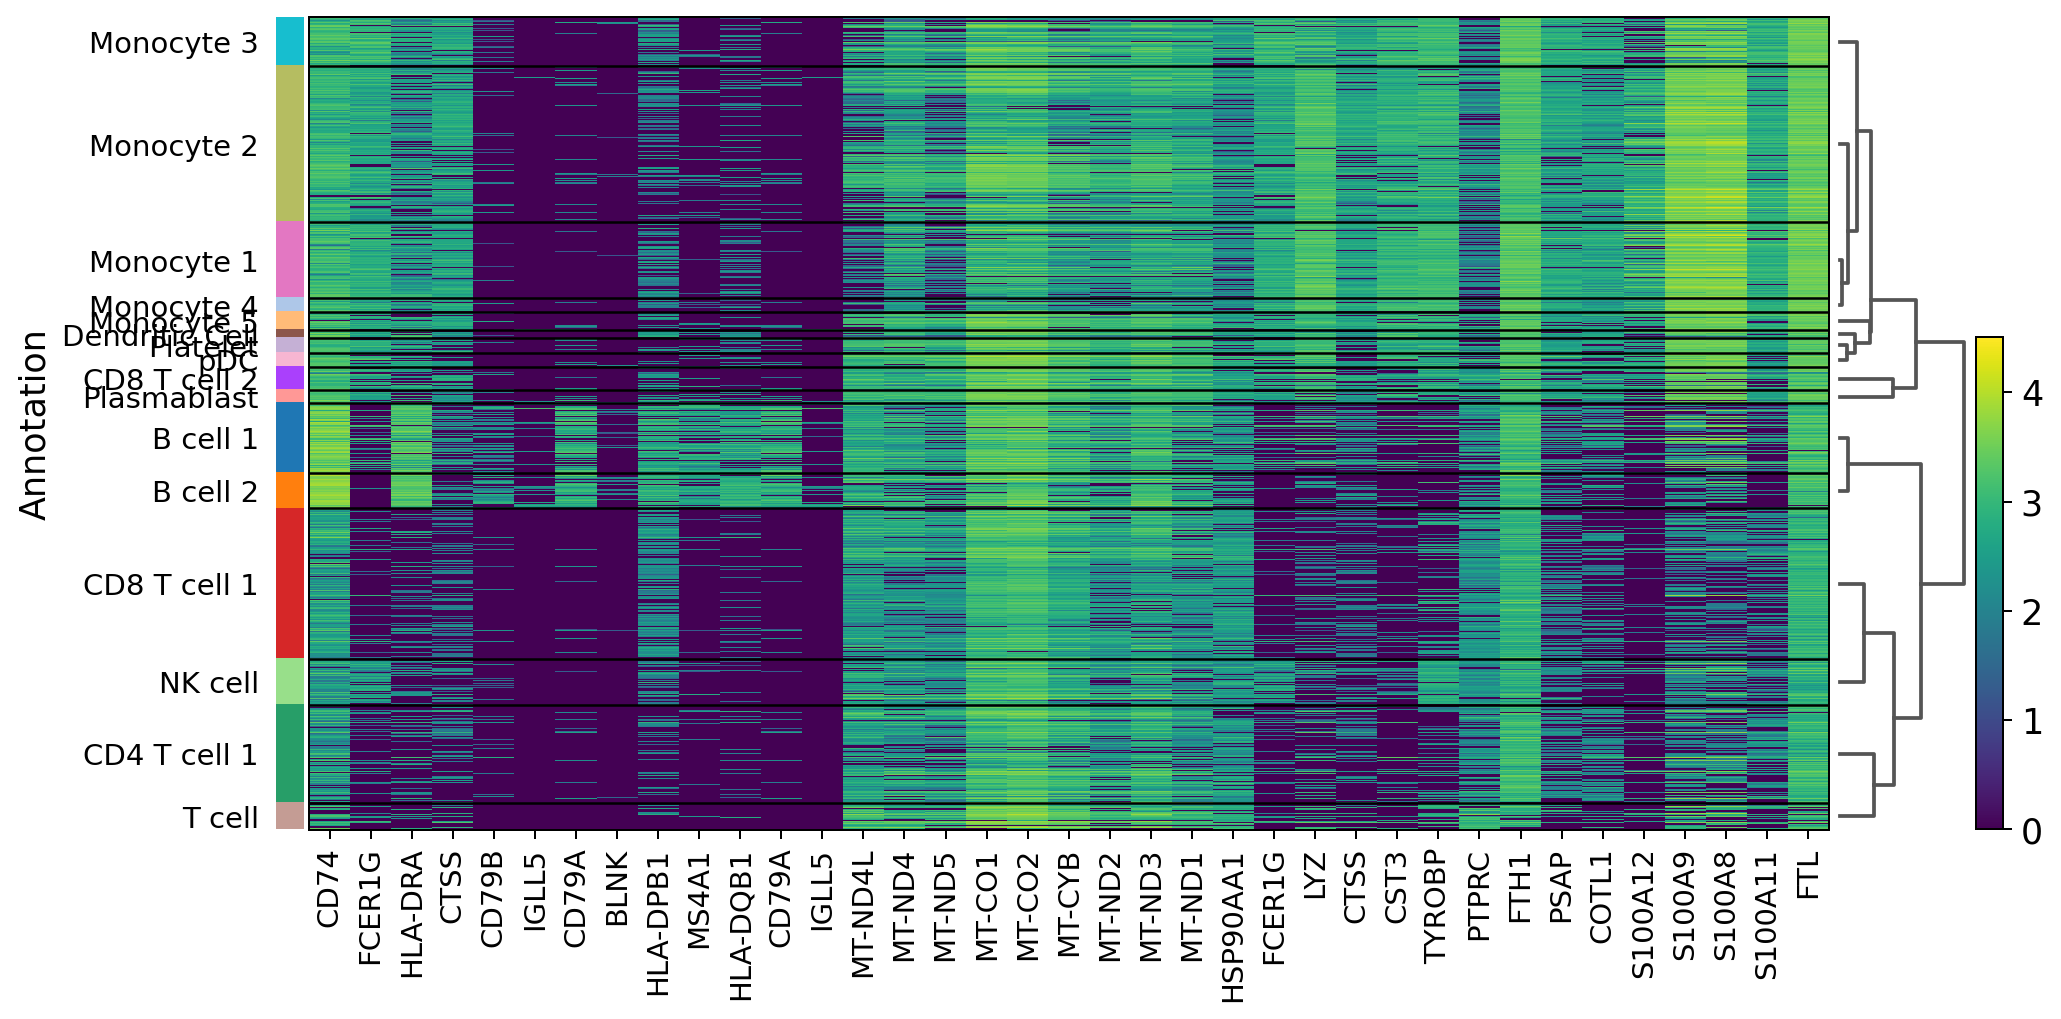

In [33]:
marker_genes = ['CD74','FCER1G','HLA-DRA','CTSS', 'CD79B','IGLL5','CD79A','BLNK','HLA-DPB1','MS4A1','HLA-DQB1', 'CD79A','IGLL5',
                 'MT-ND4L','MT-ND4','MT-ND5','MT-CO1','MT-CO2','MT-CYB','MT-ND2','MT-ND3','MT-ND1', 'HSP90AA1','FCER1G','LYZ','CTSS',
                'CST3','TYROBP','PTPRC','FTH1','PSAP','COTL1','S100A12','S100A9','S100A8','S100A11','FTL']
ax = sc.pl.heatmap(ann, marker_genes, groupby='Annotation', cmap='viridis', dendrogram=True,  save='dendrogramlow.svg', num_categories=16)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


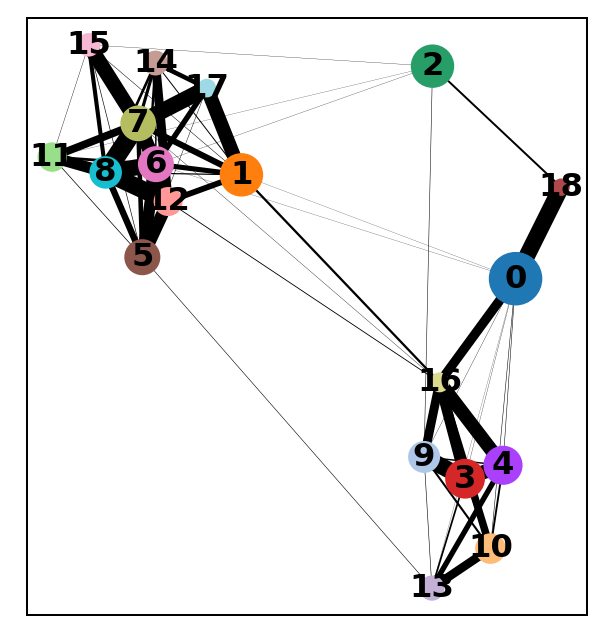

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


In [34]:
sc.tl.paga(ann)
sc.pl.paga(ann, )  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(ann, init_pos='paga' )

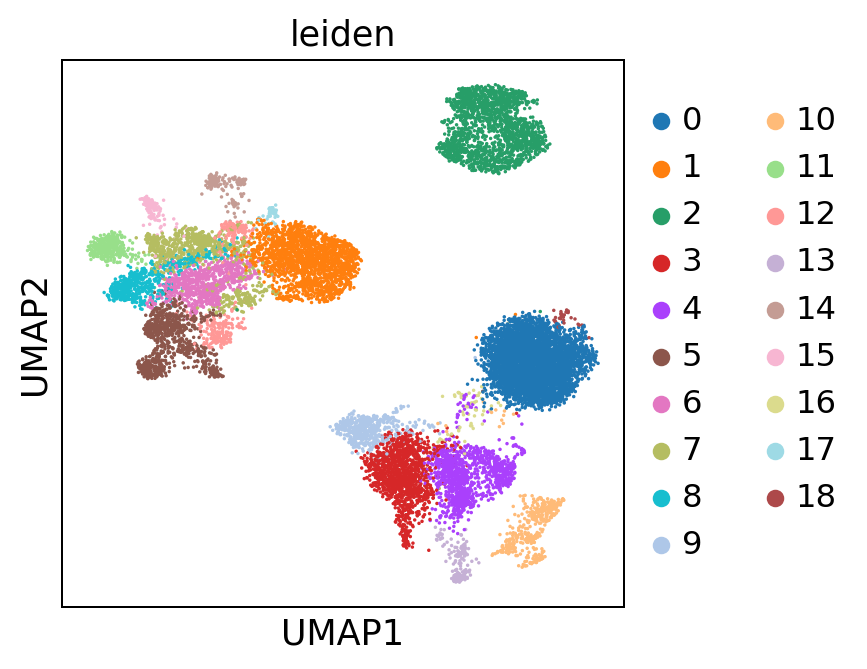

In [35]:
sc.pl.umap(ann, color=['leiden'])

**Finding marker genes**
ranking for the highly differential genes in each cluster

In [36]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:19)


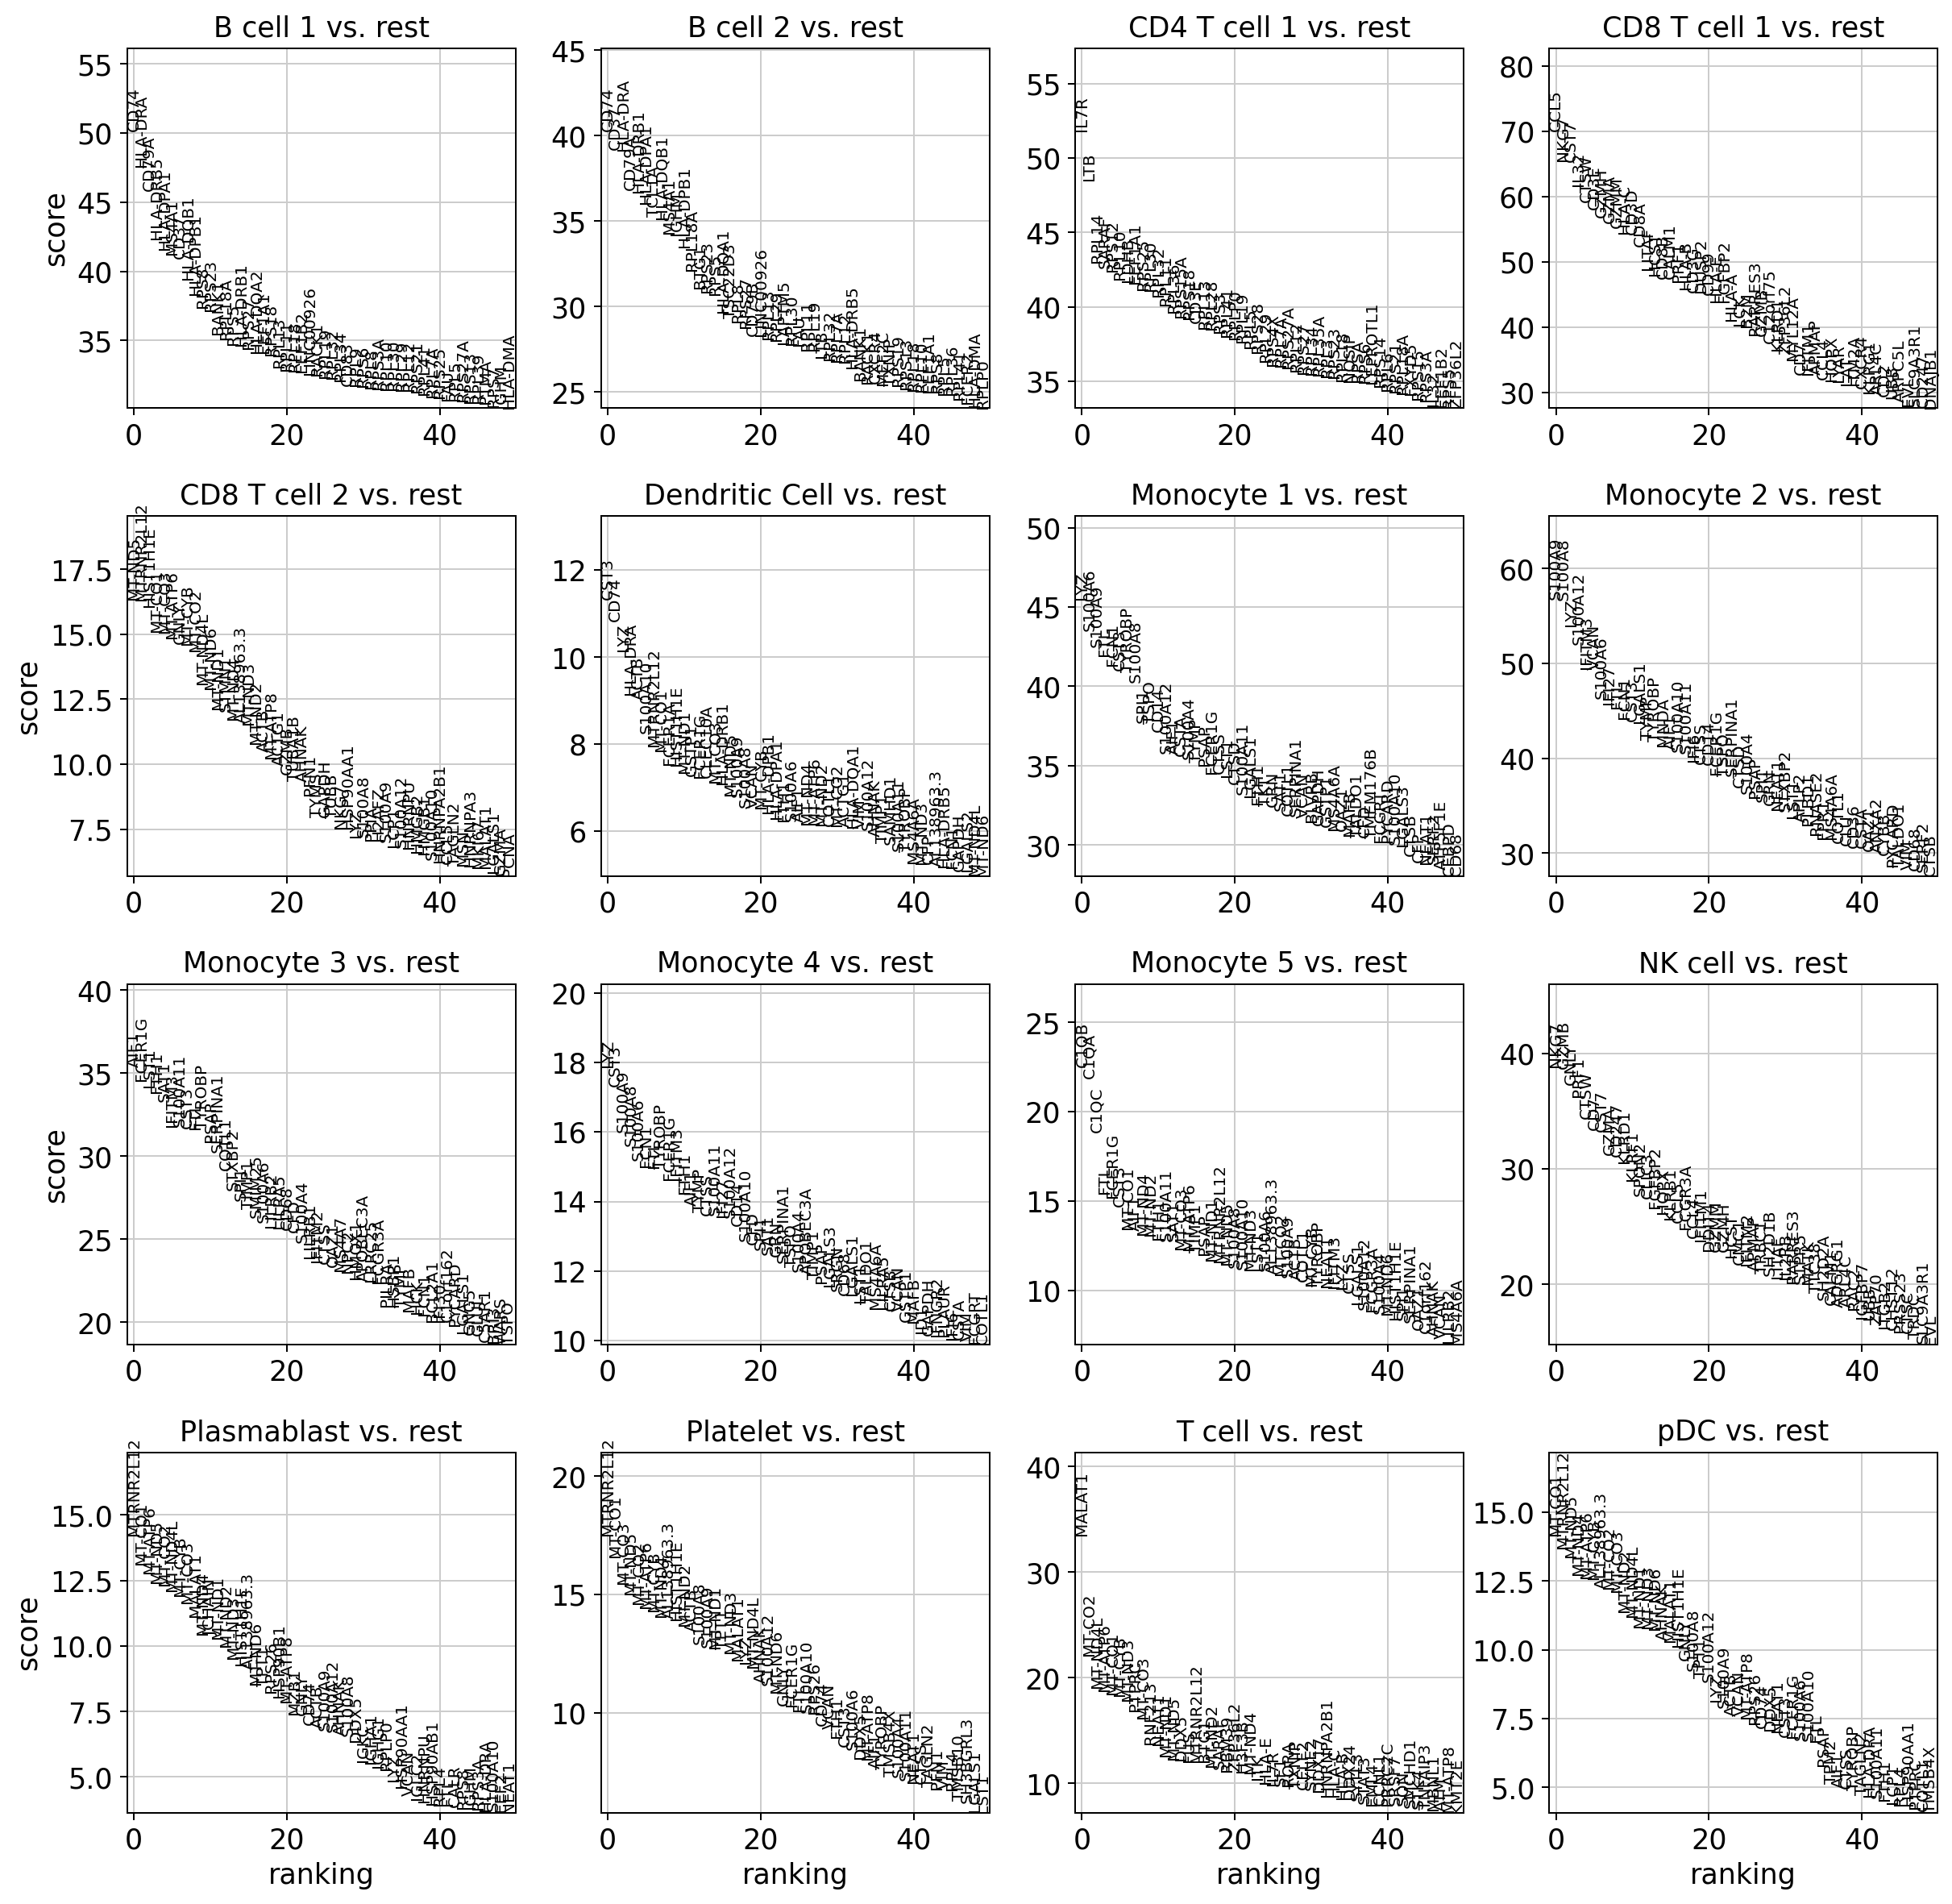

In [37]:
#Wilcoxon rank-sum (Mann-Whitney-U) test

sc.tl.rank_genes_groups(ann, 'Annotation', method='wilcoxon')
sc.pl.rank_genes_groups(ann, n_genes=50, sharey=False)

In [38]:
#Τop ranked genes per cluster

rgenes = pd.DataFrame(ann.uns['rank_genes_groups']['names']).head(5)
l_markers = []
for rg in rgenes.columns:
  lrg = rgenes[rg].to_list()
  for g in lrg:
    l_markers.append(g)
l_markers.append('KIT')

In [39]:
result = ann.uns['rank_genes_groups']
groups = result['names'].dtype.names
expr = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals', 'logfoldchanges']})

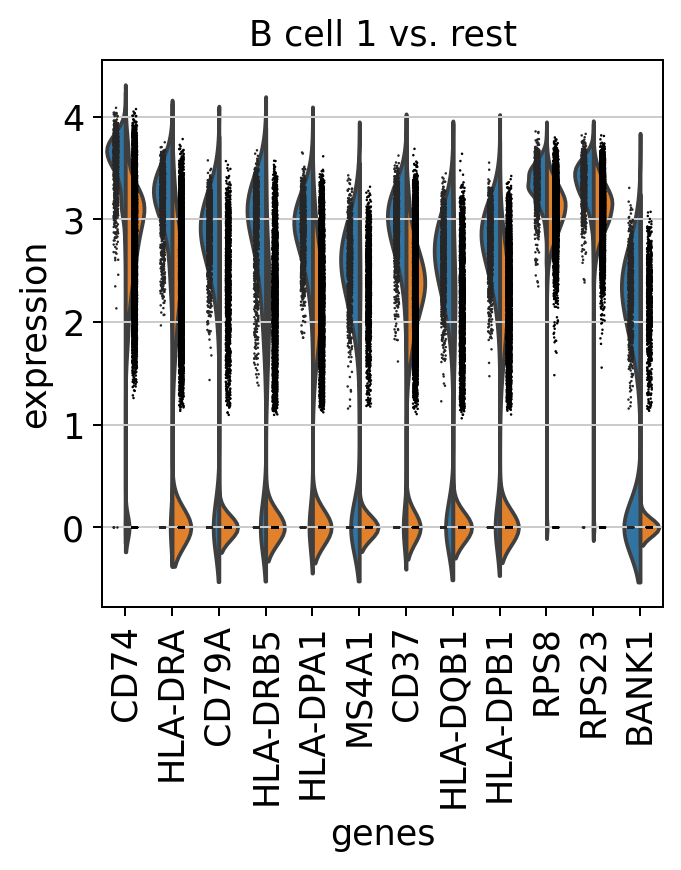

In [40]:
sc.pl.rank_genes_groups_violin(ann, groups='B cell 1', n_genes=12)

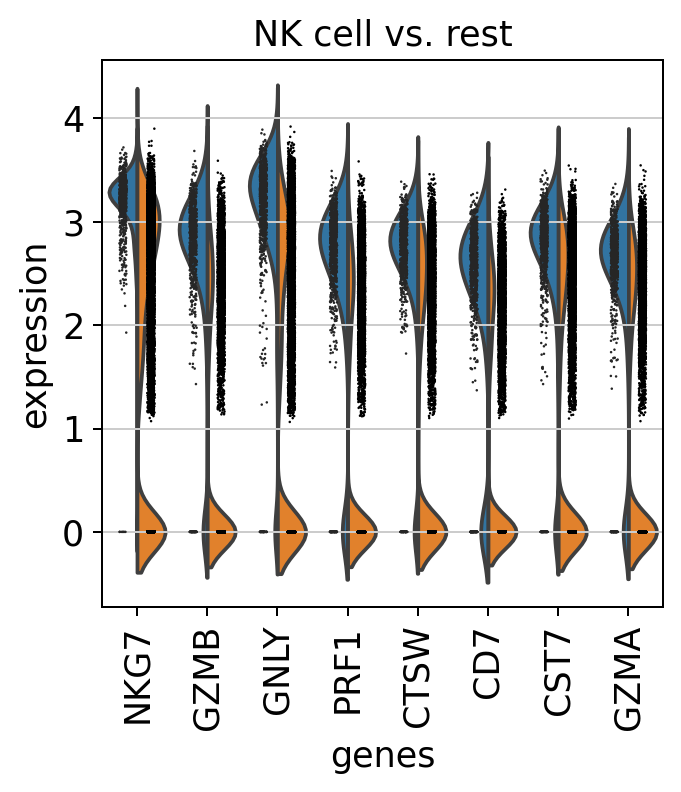

In [43]:
sc.pl.rank_genes_groups_violin(ann, groups='NK cell', n_genes=8)

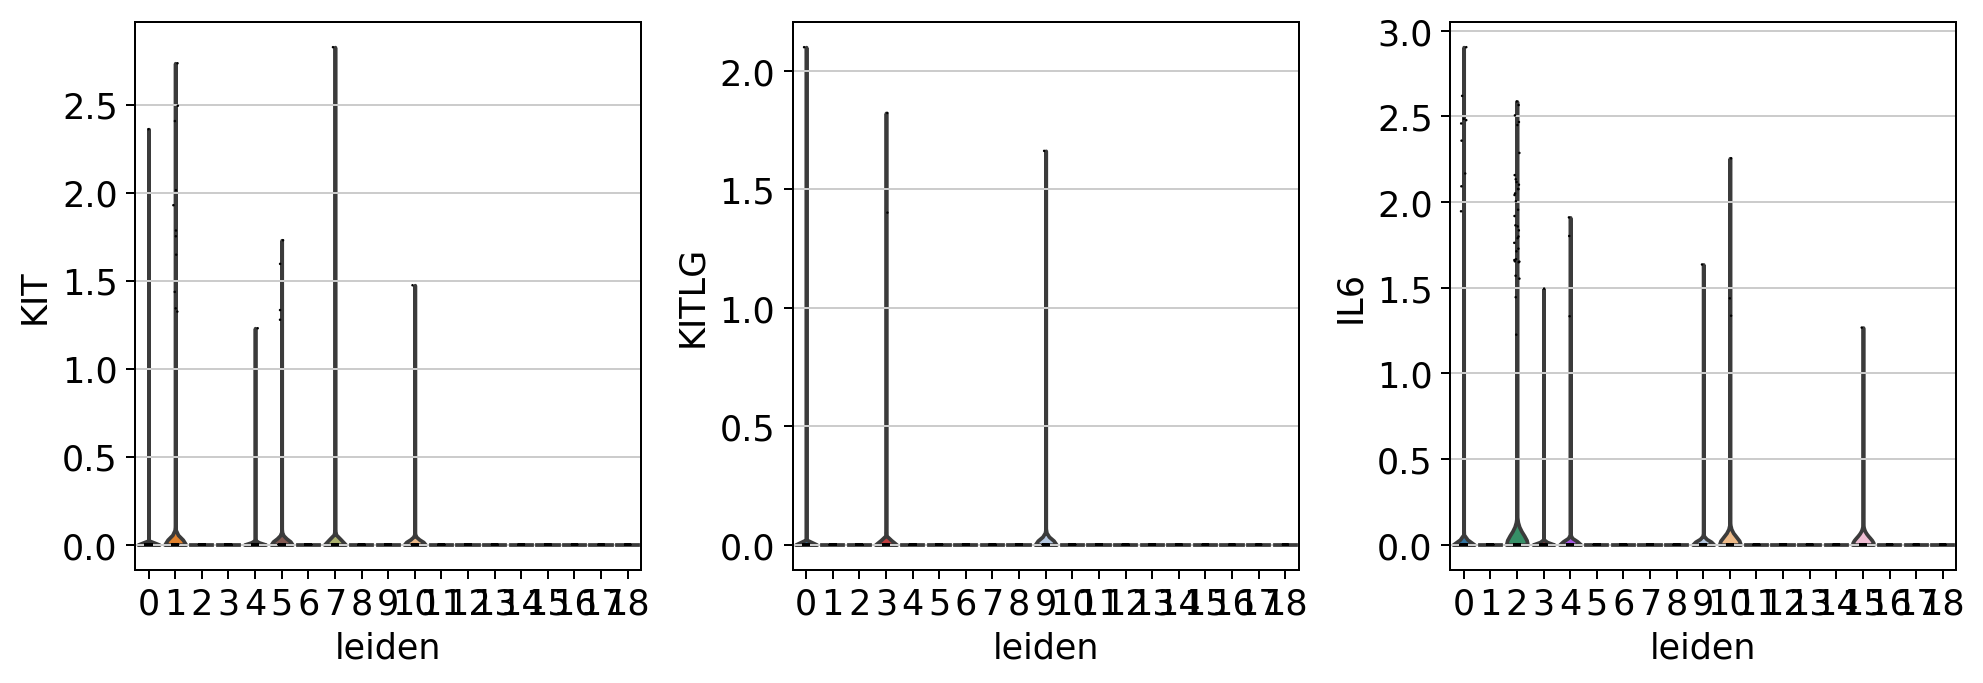

In [44]:
sc.pl.violin(ann, ['KIT', 'KITLG', 'IL6'], groupby='leiden')

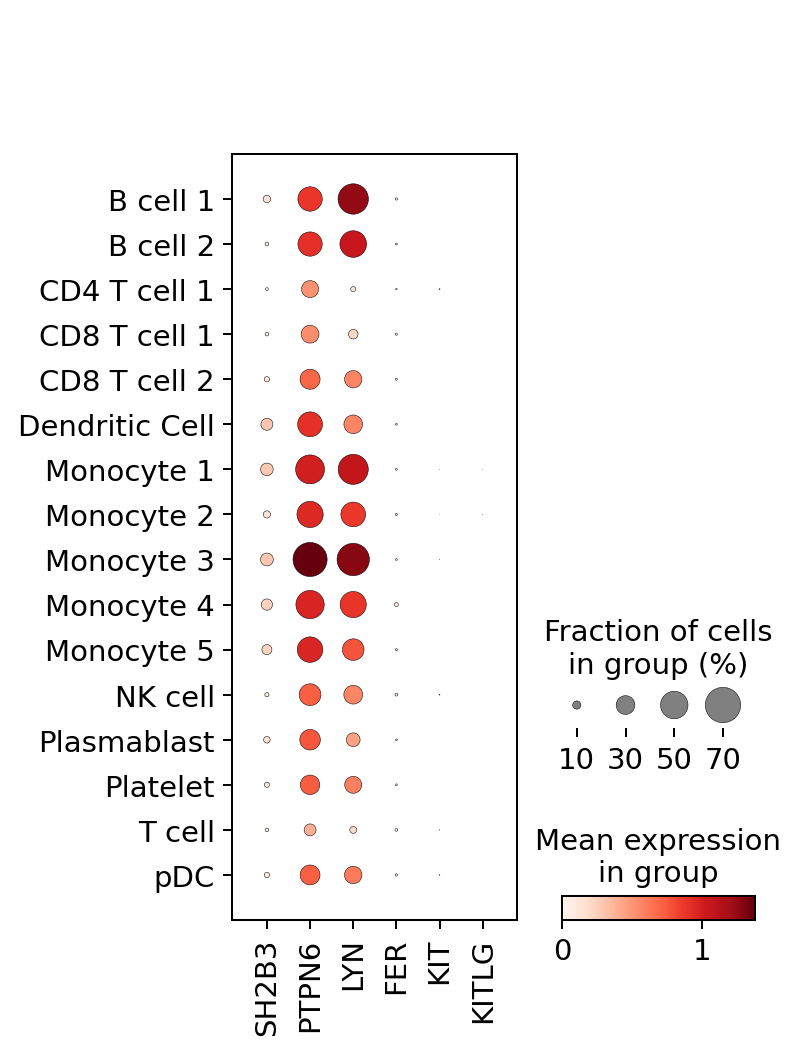

In [45]:
# marker_genes = ['CD74',	'LTB',	'CCL5',	'GNLY',	'S100A8',	'S100A9',	'APOBEC3A',	'S100A6',	'C1QA',	'GNLY',	'MT-CYB',	'ACTB',	'MALAT1',	'MT-ND5']
l_markers = ['SH2B3', 'PTPN6', 'LYN', 'FER','KIT', 'KITLG']
marker_genes = list(dict.fromkeys(l_markers))

sc.pl.dotplot(ann, marker_genes, groupby='Annotation', save='lowhSCFexplow.svg')

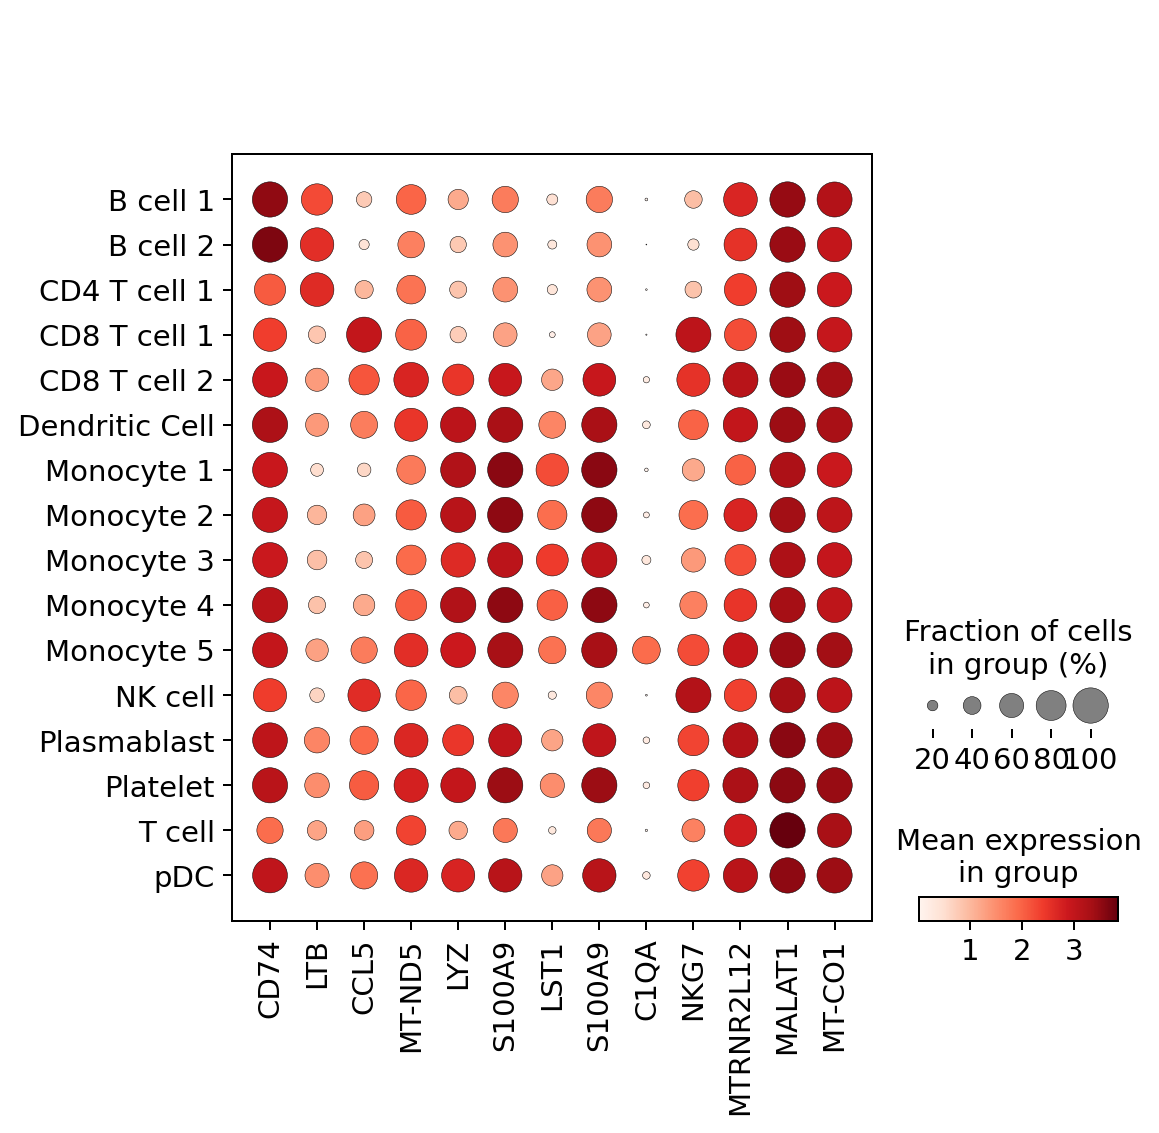

In [46]:
marker_genes=['CD74',	'LTB',	'CCL5',	'MT-ND5',	'LYZ',	'S100A9',	'LST1',	'S100A9',	'C1QA',	'NKG7',	'MTRNR2L12',	'MALAT1',	'MT-CO1']
sc.pl.dotplot(ann, marker_genes, groupby='Annotation', save='highSCFexp.svg')

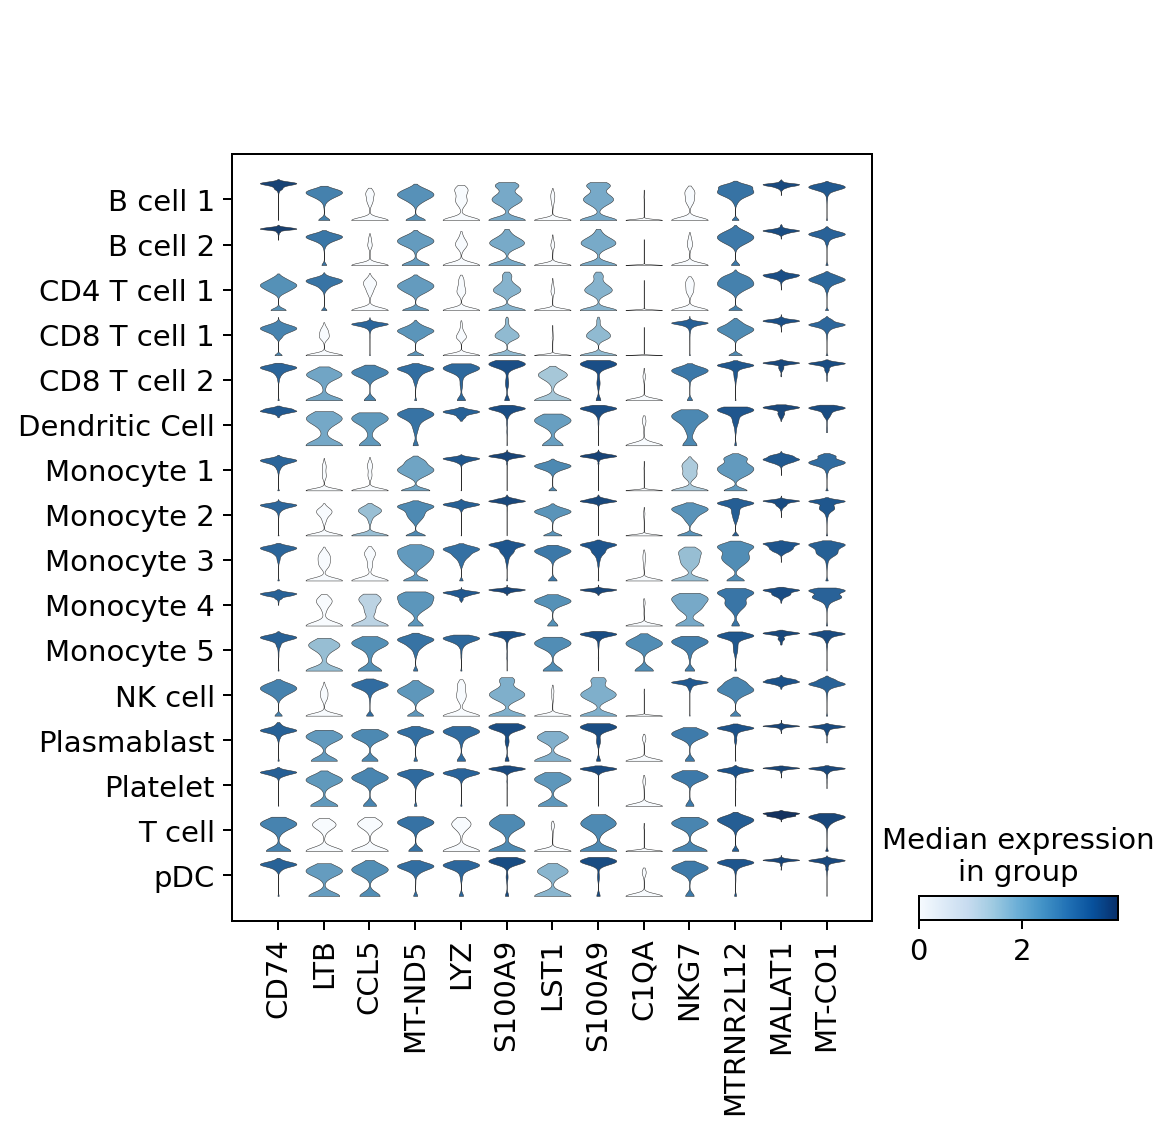

In [47]:
sc.pl.stacked_violin(ann, marker_genes, groupby='Annotation', rotation=90, save='scf_high.svg')